# creates the 6 regions mask dataset and saves to disk 

In [1]:
import os
import sys
import pathlib

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from itertools import product

In [3]:
import geopandas as gpd
import regionmask

In [4]:
import xarray as xr

### paths definitions 

In [5]:
HOME = pathlib.Path.home()

In [6]:
dpath = HOME.joinpath('operational/VCSN/data/NC/')

### open the dataset containing the VCSN grid definition 

In [7]:
dset = xr.open_dataset(dpath.joinpath('vcsn_grid_definition.nc')) 

In [8]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241)
Coordinates:
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
Data variables:
    *empty*

### read the shapefile with the NZ 6 regions 

In [9]:
nz_regions = gpd.read_file(HOME.joinpath('research/Smart_Ideas/data/shapefiles/NZ_regions/NZ_6_regions/NZ_regions_corrected.shp'))  

In [10]:
nz_regions

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,"MULTIPOLYGON (((174.70530 -38.17377, 174.70545..."
1,2,2,2,12.336015,2.994028,WNI,"MULTIPOLYGON (((175.13516 -41.37745, 175.13507..."
2,3,3,3,14.235493,3.775388,ENI,"MULTIPOLYGON (((175.85595 -41.35970, 175.85595..."
3,4,4,4,34.656463,3.066280,NSI,"MULTIPOLYGON (((171.32620 -42.12355, 171.32602..."
4,5,5,6,20.191504,4.827228,ESI,"MULTIPOLYGON (((170.21675 -46.05955, 170.21609..."
5,6,6,5,42.941379,9.057410,WSI,"MULTIPOLYGON (((169.20749 -46.66371, 169.20742..."


#### checks that the crs is correct: should be epsg 4272 

In [11]:
nz_regions.crs

<Geographic 2D CRS: EPSG:4272>
Name: NZGD49
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: New Zealand - onshore and nearshore
- bounds: (165.87, -47.65, 179.27, -33.89)
Datum: New Zealand Geodetic Datum 1949
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

### creates the regions from `regionmask`

In [12]:
regions_xarray = regionmask.from_geopandas(nz_regions)

### note the ID number for each region, order is `['NNI','WNI','ENI','NSI','ESI','WSI']`

<GeoAxesSubplot:>

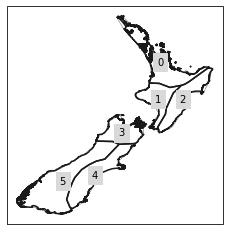

In [13]:
regions_xarray.plot()

### creates the mask 

In [14]:
regions_mask = regions_xarray.mask(dset.lon.data, dset.lat.data)

### casts to a Dataset 

In [15]:
regions_mask = regions_mask.to_dataset()

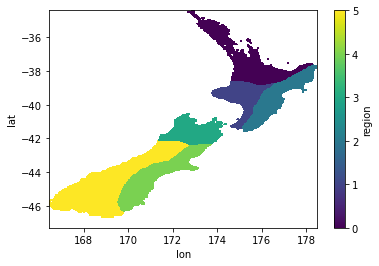

In [16]:
regions_mask['region'].plot()

### list of regions, in order 

In [17]:
list_regions = ['NNI','WNI','ENI','NSI','WSI','ESI'] 

### dictionnary mapping the region name to the region numerical ID

In [18]:
regions_dict = dict(zip(list_regions, [0,1,2,3,5,4]))

In [19]:
regions_dict

{'NNI': 0, 'WNI': 1, 'ENI': 2, 'NSI': 3, 'WSI': 5, 'ESI': 4}

### creates a mask (np.nan OR 1.) for each region 

In [20]:
for rname in list_regions:
    reg = regions_mask['region'].where(regions_mask['region']==regions_dict[rname])
    reg = reg - reg.max() + 1
    regions_mask[rname] = reg

### checks the mask values and extent 

region NNI: max val = 1
region WNI: max val = 1
region ENI: max val = 1
region NSI: max val = 1
region WSI: max val = 1
region ESI: max val = 1


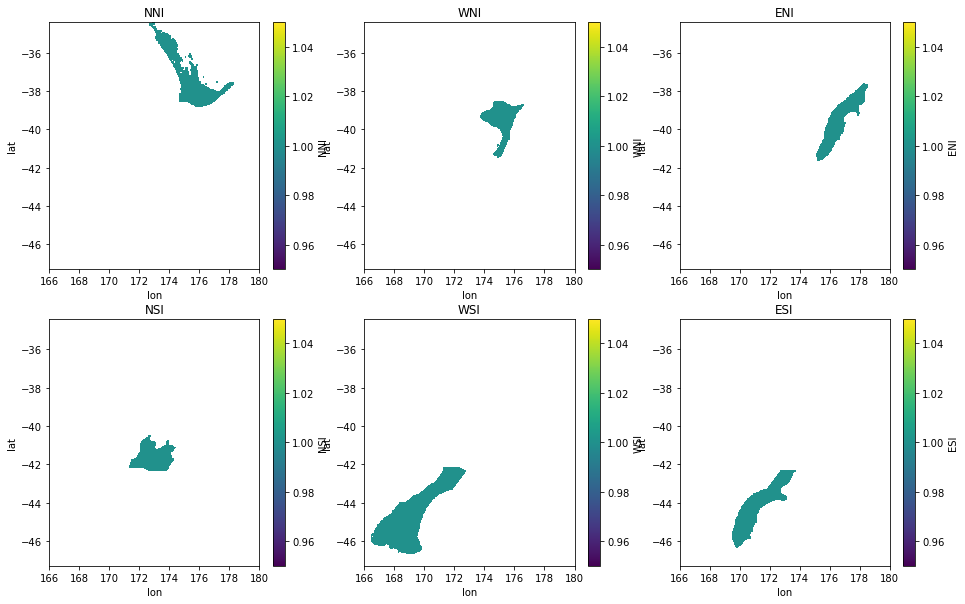

In [21]:
f, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 10))
axes = axes.ravel() 
for i, reg in enumerate(['NNI','WNI','ENI','NSI','WSI','ESI']): 
    regions_mask[reg].plot(ax=axes[i])
    print(f"region {reg}: max val = {int(regions_mask[reg].max().data) }")
    axes[i].set_title(reg)
    axes[i].set_xlim([166, 180])

### saves to disk 

In [22]:
regions_mask.to_netcdf('/media/nicolasf/END19101/data/VCSN/NZ_6_regions_mask.nc')